## Bangkit Assignment

* Annisa Sekar Ayuningtyas 
* Fajar Muslim

<hr>
Import library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
import re
from nltk.tokenize import word_tokenize
# import gensim
import string
from keras.preprocessing.text import Tokenizer # Tokenize word
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import nltk
nltk.download('punkt')



Using TensorFlow backend.
[nltk_data] Downloading package punkt to /home/fajar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
from tensorflow.python.client import device_lib

In [3]:
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:XLA_CPU:0']


In [4]:
import tensorflow as tf
print ("TensorFlow version: " + tf.__version__)
# Note you no longer need to import keras, use tf.keras instead

TensorFlow version: 1.13.1


In [5]:
import keras

print(keras.__version__)

2.2.5


<hr>
Loading the data and getting basic idea 

In [303]:
train= pd.read_csv("raw_data/train.csv")
test=pd.read_csv("raw_data/test.csv")

In [304]:
print('Train has {} rows and {} columns'.format(train.shape[0],train.shape[1]))
print('Test has {} rows and {} columns'.format(test.shape[0],test.shape[1]))

Train has 7613 rows and 5 columns
Test has 3263 rows and 4 columns


In [305]:
#check the data
train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [306]:
test.head(5)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


seems that keyword and location has lot of nan so far, let's inspect the data deeper

In [307]:
# How many percentage nan data in every column in train_df
(train.isna().sum() / len(train)) * 100

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

In [308]:
# How many percentage nan data in every column in test_df
(test.isna().sum() / len(test)) * 100

id           0.000000
keyword      0.796813
location    33.864542
text         0.000000
dtype: float64

Here we know that
* Actually the keyword has a little missing value, only 0.8 percent at train and test data
* The distribution of missing value in train and test are similar. We can assume that the source of the data is same and train test split is going better

In [309]:
# See the how many many percentage of the unique data in every column in the data train
(train.nunique() / len(train)) *100

id          100.000000
keyword       2.902929
location     43.885459
text         98.555103
target        0.026271
dtype: float64

In [310]:
# See the how many many percentage of the unique data in every column in the data test
(test.nunique() / len(test)) *100

id          100.000000
keyword       6.772908
location     49.095924
text         99.387067
dtype: float64

In [311]:
# The data seems have an tweet that repeated
# Lets check it
train[train.duplicated(['text'])].sort_values('text')

,id,keyword,location,text,target
4299,6105,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it...,0
4312,6123,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it...,1
6366,9098,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6373,9107,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6392,9135,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6377,9113,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6378,9114,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
2828,4064,displaced,NaN,#KCA #VoteJKT48ID 12News: UPDATE: A family of ...,1
2841,4086,displaced,Pedophile hunting ground,#Myanmar Displaced #Rohingya at #Sittwe point...,1
1725,2488,collided,"Peterborough, Ont.",#Newswatch: 2 vehicles collided at Lock and La...,1


There are tweet that same but have different label
for example in the data with the index 6094 and 6123 have different label, though it is have same text. This is a bit confusing

In [312]:
train.iloc[6123]['text'] == train.iloc[6123]['text']

True

The text in the some tweet is same, maybe it is a retweet

comparing amount of both target class :
0    4342
1    3271
Name: target, dtype: int64 



Text(0,0.5,'amount')

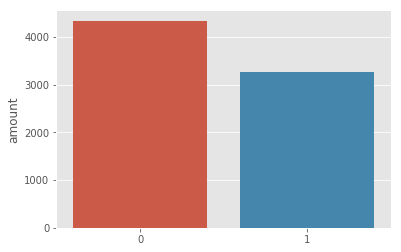

In [313]:
print("comparing amount of both target class :")
count_value = train['target'].value_counts()
print(count_value,"\n")

sns.barplot(count_value.index,count_value)
plt.gca().set_ylabel('amount')

There are more tweet "No disaster" (class 0) than "Disaster" tweet (class 1)

<hr>
Inspect text deeper

Count character in tweets at the train data

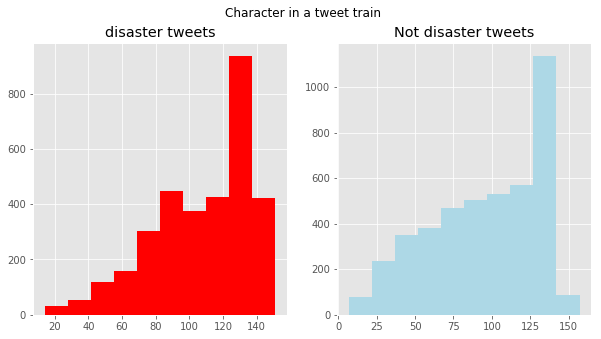

In [314]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='lightblue')
ax2.set_title('Not disaster tweets')
fig.suptitle('Character in a tweet train')
plt.show()

Count character in train and test data

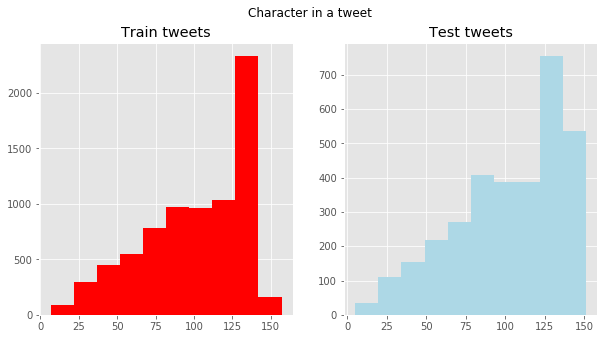

In [315]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('Train tweets')
tweet_len=test['text'].str.len()
ax2.hist(tweet_len,color='lightblue')
ax2.set_title('Test tweets')
fig.suptitle('Character in a tweet')
plt.show()

count of word in the tweets train

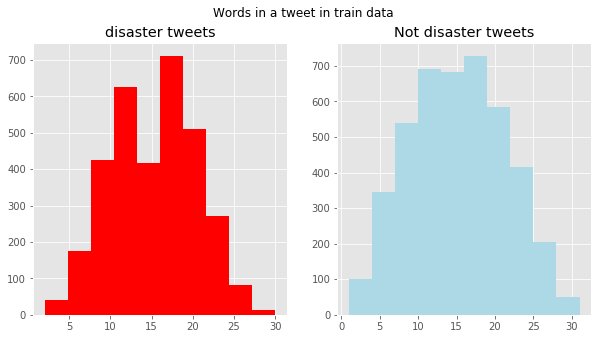

In [316]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='lightblue')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet in train data')
plt.show()

Count of words in train and test data

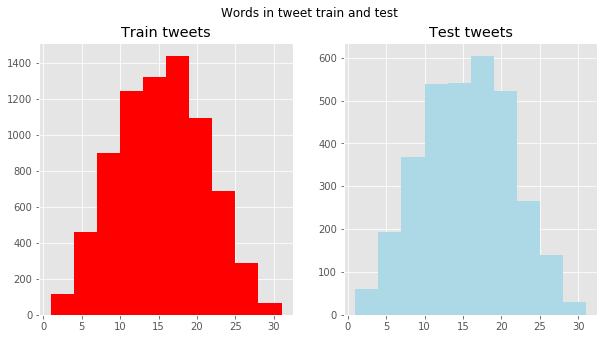

In [317]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('Train tweets')
tweet_len=test['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='lightblue')
ax2.set_title('Test tweets')
fig.suptitle('Words in tweet train and test')
plt.show()

## Data Cleaning

In [318]:
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from collections import defaultdict
from collections import  Counter
from spellchecker import SpellChecker
import re
import string

In [319]:
print("remove URL")
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

train["text"] = [remove_URL(text) for text in train["text"]]
test["text"] = [remove_URL(text) for text in test["text"]]

remove URL


In [320]:
print("remove HTML tag")
def remove_html_tag(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

train["text"] = [remove_html_tag(text) for text in train["text"]]
test["text"] = [remove_html_tag(text) for text in test["text"]]

remove HTML tag


In [321]:
print("remove emoji")
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

train["text"] = [remove_emoji(text) for text in train["text"]]
test["text"] = [remove_emoji(text) for text in test["text"]]

remove emoji


In [322]:
print("Remove punctuation")
def remove_punctuation(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

train["text"] = [remove_punctuation(text) for text in train["text"]]
test["text"] = [remove_punctuation(text) for text in test["text"]]

Remove punctuation


In [323]:
# print("spell checking")
# spell = SpellChecker()

# def correct_spellings(text):
#     corrected_text = []
#     # find those words that may be misspelled
#     misspelled_words = spell.unknown(text.split())
#     for word in text.split():
#         if word in misspelled_words:
#             corrected_text.append(spell.correction(word))
#         else:
#             corrected_text.append(word)
#     return " ".join(corrected_text)

# train["text"] = [correct_spellings(text) for text in train["text"]]
# test["text"] = [correct_spellings(text) for text in test["text"]]

In [324]:
print("Tokenization")

train['text'] = [word_tokenize(text) for text in train["text"]]
test['text'] = [word_tokenize(text) for text in test["text"]]

Tokenization


In [325]:
print("Normalization")

train['text'] = [[word.lower() for word in text]for text in train["text"]]
test['text'] = [[word.lower() for word in text]for text in test["text"]]

Normalization


In [326]:
print("Remove stopwords")

stop_words = set(stopwords.words('english'))
train['text'] = [[word for word in text if not word in stop_words] for text in train["text"]]
test['text'] = [[word for word in text if not word in stop_words] for text in test["text"]]

Remove stopwords


In [327]:
print("Remove non alphabetic")

train['text'] = [[word for word in text if word.isalpha()] for text in train["text"]]
test['text'] = [[word for word in text if word.isalpha()] for text in test["text"]]

Remove non alphabetic


In [328]:
# concat train and test data
df=pd.concat([train,test])
df.shape

/home/fajar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


(10876, 5)

<hr>
Using glove pretrained corpus model to represent word

In [329]:
stop=set(stopwords.words('english'))
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in tweet if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [330]:
corpus=create_corpus(df)
# df

100%|██████████| 10876/10876 [00:00<00:00, 63689.27it/s]


In [331]:
embedding_dict={}
with open('raw_data/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [332]:
MAX_LEN=40
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [333]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 20221


In [334]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 20221/20221 [00:00<00:00, 404698.27it/s]


In [335]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(lr=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [336]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 100)           2022200   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 40, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 2,102,701
Trainable params: 80,501
Non-trainable params: 2,022,200
_________________________________________________________________


In [337]:
train=tweet_pad[:train.shape[0]]
test=tweet_pad[train.shape[0]:]

In [338]:
X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 40)
Shape of Validation  (1142, 40)


In [339]:
history=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)

Train on 6471 samples, validate on 1142 samples
Epoch 1/15
 - 62s - loss: 0.6911 - acc: 0.5719 - val_loss: 0.6899 - val_acc: 0.5560
Epoch 2/15
 - 61s - loss: 0.6775 - acc: 0.5795 - val_loss: 0.6340 - val_acc: 0.6261
Epoch 3/15
 - 58s - loss: 0.6031 - acc: 0.6891 - val_loss: 0.5339 - val_acc: 0.7662
Epoch 4/15
 - 58s - loss: 0.5757 - acc: 0.7215 - val_loss: 0.5171 - val_acc: 0.7697
Epoch 5/15
 - 58s - loss: 0.5723 - acc: 0.7306 - val_loss: 0.5107 - val_acc: 0.7618
Epoch 6/15
 - 57s - loss: 0.5624 - acc: 0.7364 - val_loss: 0.5053 - val_acc: 0.7662
Epoch 7/15
 - 58s - loss: 0.5536 - acc: 0.7416 - val_loss: 0.5022 - val_acc: 0.7671
Epoch 8/15
 - 57s - loss: 0.5436 - acc: 0.7461 - val_loss: 0.4999 - val_acc: 0.7671
Epoch 9/15
 - 57s - loss: 0.5476 - acc: 0.7452 - val_loss: 0.4957 - val_acc: 0.7662
Epoch 10/15
 - 57s - loss: 0.5444 - acc: 0.7507 - val_loss: 0.4975 - val_acc: 0.7662
Epoch 11/15
 - 57s - loss: 0.5376 - acc: 0.7561 - val_loss: 0.4946 - val_acc: 0.7680
Epoch 12/15
 - 59s - loss:

In [340]:
sample_submission =pd.read_csv('raw_data/sample_submission.csv')

In [341]:
y_pre=model.predict(test)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_submission['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)

In [342]:
sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
